In [1]:
import pandas as pd
import numpy as np
import os
import json
import statistics
import pandas as pd
import numpy as np
import scipy.stats as stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from dateutil import parser
import datetime
import matplotlib.pyplot as plt
from dateutil.tz import tzutc
import math

In [2]:
d = "./result_final"

dirs_to_analyze = [os.path.join(d, o) for o in os.listdir(d) 
                    if os.path.isdir(os.path.join(d,o)) and "\\experiment" in os.path.join(d, o)]


In [3]:
rowsList = []
numjobs = []
batches = []

for curdir in dirs_to_analyze:
    row = {}    
    try:
        time_summary = json.load(open(curdir + "/summary.json"))
        service_times = []
        process_times = []
        wait_times = []
        
        start_time = parser.parse(time_summary["start"])
        end_time = parser.parse(time_summary["shutdown"])

        time_offset = datetime.timedelta(minutes=30)
        batch_start_time = start_time + time_offset

        batch_start_seconds = (batch_start_time-datetime.datetime(1970,1,1).replace(tzinfo=tzutc())).total_seconds()
        end_seconds = (end_time.replace(tzinfo=None)-datetime.datetime(1970,1,1)).total_seconds()

        num_batches = 4

        batch_delta = (end_seconds - batch_start_seconds) / float(num_batches)


        batch_num = 0
        batch_jobs = []

        for batch_start in np.arange(batch_start_seconds, end_seconds, batch_delta):
            batch_num = batch_num + 1
#             print("Batch ", batch_num)
#             print(batch_start, " - ", batch_start + batch_delta)
            new_batch_jobs = []

            i = -1
            for job in time_summary['jobs']:
                i = i + 1
                if (float(job['end']) >= batch_start) & (float(job['end']) < batch_start + batch_delta):
                    new_batch_jobs.append(i)

#             print("Num jobs", len(new_batch_jobs))
            numjobs.append(len(new_batch_jobs))
            batch_jobs.append(new_batch_jobs)
        
        batches.append(batch_jobs)
        
        row['Num generated'] = time_summary['jobCount']

        for job in time_summary['jobs']:
            service_time = float(job['end']) - float(job['arrive'])
            service_times.append(service_time)
            wait_time = float(job['start']) - float(job['arrive'])
            wait_times.append(wait_time)
            process_time = float(job['end']) - float(job['start'])
            process_times.append(process_time)

        row['Service Time mean'] = statistics.mean(service_times)
        row['Service Time std'] = statistics.stdev(service_times)
        row['Process Time mean'] = statistics.mean(process_times)
        row['Process Time std'] = statistics.stdev(process_times)
        row['Waiting Time mean'] = statistics.mean(wait_times)
        row['Waiting Time std'] = statistics.stdev(wait_times)
    except Exception as e:
        print("Error parsing time summary for folder " + curdir)
        print(e)
        
    try:
        config = json.load(open(curdir + "/config.json"))
        row['Executor Memory'] = int(config['jobClassParameters'][0]['systemParameters']['executorMemory'][:1])
        row['Batch Size'] = int(config['jobClassParameters'][0]['hyperParameters']['batchSize'])
        row['Max Epochs'] = int(config['jobClassParameters'][0]['hyperParameters']['maxEpoch'])
        row['Learning Rate'] = float(config['jobClassParameters'][0]['hyperParameters']['learningRate'])
#         row['Learning Rate Decay'] = float(config['jobClassParameters'][0]['hyperParameters']['learningrateDecay'])
        row['Nodes'] = int(config['numberOfNodes'])
        row['Lambda'] = float(config['lambda'])

    except Exception as e:
        print("Error parsing config for folder " + curdir)
        print(e)
        
    try:
        accuracy = pd.read_json(curdir + "/accuracy.json").transpose()
        row['Num finished'] = accuracy["top1"].count()
        row['Top 1 mean'] = accuracy["top1"].mean()
        row['Top 1 std'] = accuracy["top1"].std()
        row['Top 5 mean'] = accuracy["top5"].mean()
        row['Top 5 std'] = accuracy["top5"].std()
        row['loss mean'] = accuracy["loss"].mean()
        row['loss std'] = accuracy["loss"].std()
        row['lossnum'] = accuracy["lossnum"].mean()
    except Exception as e:
        print("Error parsing accuracy for folder " + curdir)
        print(e)
        
    
    rowsList.append(row) 
    
analysis_old = pd.DataFrame(rowsList)
# analysis_old

In [4]:
# mu = analysis["Top 1 mean"].mean()
# sigma = analysis["Top 1 mean"].std()
mu = 0.9
sigma = 0.05
def z_score(x, mu, sig):
    return (x-mu)/sig

In [79]:
## Creating batches
rowsList = []
numjobs = []

new_df = pd.DataFrame(columns=analysis_old.columns)
i = -1
for curdir in dirs_to_analyze:
#     print(curdir)
    i = i + 1
    time_summary = json.load(open(curdir + "/summary.json"))
    config = json.load(open(curdir + "/config.json"))
    accuracy = pd.read_json(curdir + "/accuracy.json").transpose()
    accuracy["Experiment"] = [int(x.split(".")[0]) for x in accuracy.index]

    experiment_batches = batches[i]
    batch_num = 0
    for curbat in experiment_batches:
        batch_num = batch_num + 1
        if len(curbat) == 0:
            continue
        row = {}
        
        service_times = []
        process_times = []
        wait_times = []
        batch_summary = time_summary['jobs'][min(curbat):max(curbat)+1]
        for job in batch_summary:
            service_time = float(job['end']) - float(job['arrive'])
            service_times.append(service_time)
            wait_time = float(job['start']) - float(job['arrive'])
            wait_times.append(wait_time)
            process_time = float(job['end']) - float(job['start'])
            process_times.append(process_time)
        row['Batch Number'] = batch_num
        row['Experiment Number'] = i
        row['Service Time mean'] = statistics.mean(service_times)
        row['Process Time mean'] = statistics.mean(process_times)
        row['Waiting Time mean'] = statistics.mean(wait_times)
        row['Executor Memory'] = int(config['jobClassParameters'][0]['systemParameters']['executorMemory'][:1])
        row['Batch Size'] = int(config['jobClassParameters'][0]['hyperParameters']['batchSize'])
        row['Max Epochs'] = int(config['jobClassParameters'][0]['hyperParameters']['maxEpoch'])
        row['Learning Rate'] = float(config['jobClassParameters'][0]['hyperParameters']['learningRate'])
#         row['Learning Rate Decay'] = float(config['jobClassParameters'][0]['hyperParameters']['learningrateDecay'])
        row['Nodes'] = int(config['numberOfNodes'])
        row['Lambda'] = float(config['lambda'])
        
        
        row['Experiment Name'] = str(row['Batch Size']) + "/" + str(row['Max Epochs']) + "/" + str(row['Learning Rate'])
        row['Experiment Name Long'] = str(row['Batch Size']) + "/" + str(row['Max Epochs']) + "/" + str(row['Learning Rate']) + "-" + str(row['Nodes'])

        batch_accuracy = accuracy[accuracy["Experiment"].isin(curbat)]
        row['Num finished'] = batch_accuracy["top1"].count()
        row['Top 1 mean'] = batch_accuracy["top1"].mean()
        row['Top 1 std'] = batch_accuracy["top1"].std()
        row['Top 5 mean'] = batch_accuracy["top5"].mean()
        row['Top 5 std'] = batch_accuracy["top5"].std()
        row['loss mean'] = batch_accuracy["loss"].mean()
        row['loss std'] = batch_accuracy["loss"].std()
        row['lossnum'] = batch_accuracy["lossnum"].mean()
        row['Zscore1'] = z_score(row['Top 1 mean'], mu, sigma)
        row['Zscore5'] = z_score(row['Top 5 mean'], mu, sigma)
        row['Zscore1'] = z_score(row['Top 1 mean'], mu, sigma)
        row['Zscore5'] = z_score(row['Top 5 mean'], mu, sigma)
        row['EZscore1'] = math.e**row['Zscore1'] /  row['Service Time mean']
        row['EZscore5'] = math.e**row['Zscore5'] / row['Service Time mean']
        row['EZscore1Nodes'] = math.e**row['Zscore1'] /  (row['Service Time mean'] * row['Nodes'])
        row['EZscore1Nodes+'] = math.e**row['Zscore1'] /  (row['Service Time mean'] * (row['Nodes']+1))

        rowsList.append(row) 
    
analysis_batch = pd.DataFrame(rowsList)
analysis_batch

,Batch Number,Experiment Number,Service Time mean,Process Time mean,Waiting Time mean,Executor Memory,Batch Size,Max Epochs,Learning Rate,Nodes,...,Top 5 std,loss mean,loss std,lossnum,Zscore1,Zscore5,EZscore1,EZscore5,EZscore1Nodes,EZscore1Nodes+
0,1,0,328.272120,328.272021,0.000099,1,128,5,0.020,1,...,0.000171,0.174174,0.009153,157.0,0.979500,1.977500,0.008113,0.022008,0.008113,0.004056
1,2,0,314.481522,266.241449,48.240073,1,128,5,0.020,1,...,0.000469,0.167423,0.010919,157.0,1.028500,1.974000,0.008894,0.022893,0.008894,0.004447
2,3,0,286.685161,286.685056,0.000105,1,128,5,0.020,1,...,0.000153,0.168750,0.010666,157.0,1.039333,1.978667,0.009862,0.025230,0.009862,0.004931
3,4,0,390.242862,307.857159,82.385704,1,128,5,0.020,1,...,0.000359,0.165596,0.017775,157.0,1.065500,1.976500,0.007437,0.018495,0.007437,0.003719
4,1,1,210.033468,210.033413,0.000054,1,128,5,0.020,2,...,0.000456,0.172249,0.007794,157.0,0.994000,1.975200,0.012865,0.034319,0.006432,0.004288
5,2,1,190.475774,190.475728,0.000046,1,128,5,0.020,2,...,0.000141,0.165609,0.007137,157.0,1.064000,1.978000,0.015214,0.037949,0.007607,0.005071
6,3,1,202.976443,202.976382,0.000061,1,128,5,0.020,2,...,0.000513,0.183368,0.020345,157.0,0.945334,1.969333,0.012680,0.035304,0.006340,0.004227
7,4,1,194.094318,194.094274,0.000044,1,128,5,0.020,2,...,0.000173,0.161221,0.008532,157.0,1.060667,1.980000,0.014881,0.037316,0.007440,0.004960
8,1,2,201.217319,201.217267,0.000052,1,128,5,0.020,4,...,0.000195,0.168030,0.004726,157.0,1.027600,1.977200,0.013887,0.035894,0.003472,0.002777
9,2,2,205.304069,205.304011,0.000058,1,128,5,0.020,4,...,0.000329,0.176235,0.010636,157.0,0.967600,1.975200,0.012818,0.035109,0.003205,0.002564


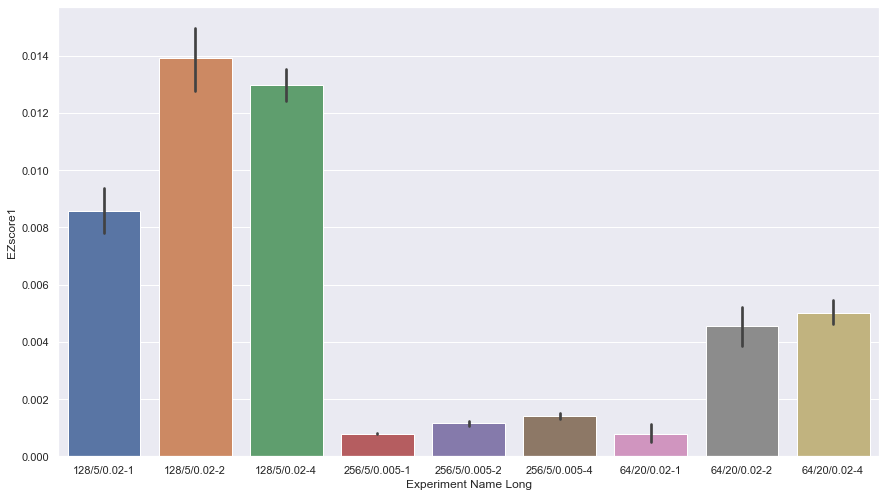

In [80]:
import seaborn as sns
sns.set(rc={'figure.figsize':(14.7,8.27)})

sns.barplot(x="Experiment Name Long", y="EZscore1", data=analysis_batch, ci=90)

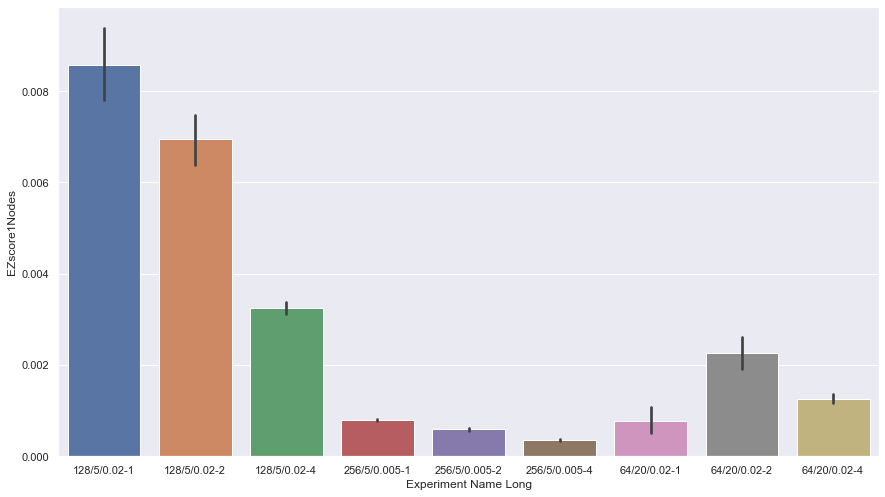

In [81]:
sns.barplot(x="Experiment Name Long", y="EZscore1Nodes", data=analysis_batch, ci=90)

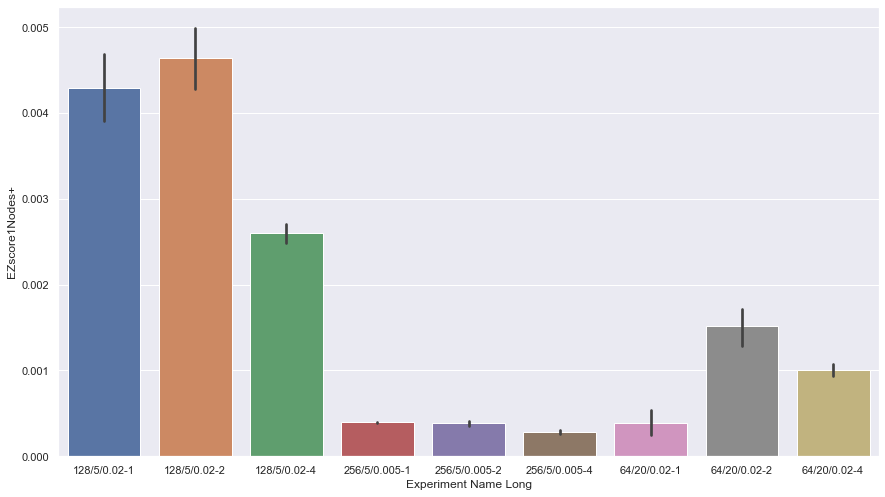

In [82]:
sns.barplot(x="Experiment Name Long", y="EZscore1Nodes+", data=analysis_batch, ci=90)

(0.8, 1.0)

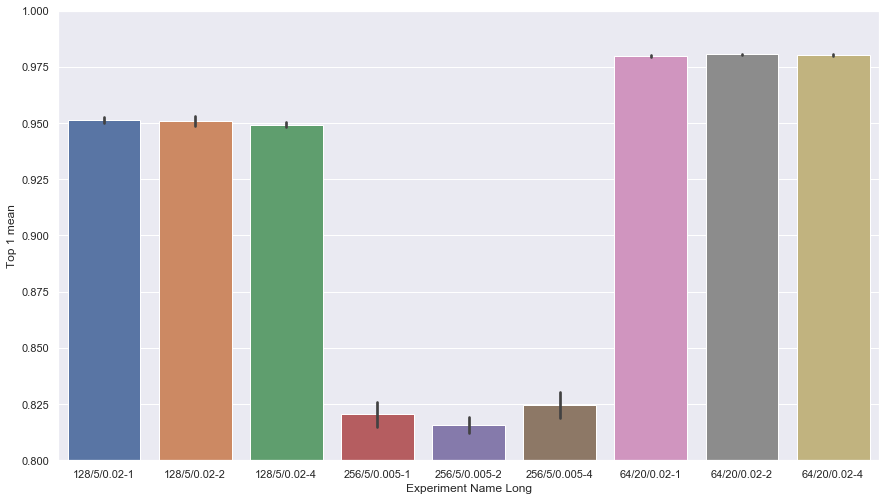

In [83]:
bp = sns.barplot(x="Experiment Name Long", y="Top 1 mean", data=analysis_batch, ci=90)
axes = bp.axes
axes.set_ylim(0.8,1.0)

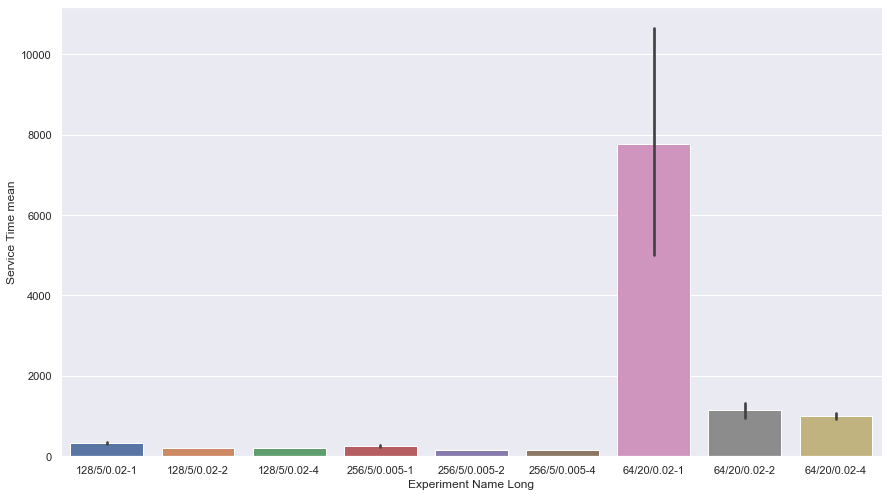

In [84]:
sns.barplot(x="Experiment Name Long", y="Service Time mean", data=analysis_batch, ci=90)


In [87]:
# Fits the model with the interaction term
analysis2 = analysis_batch[["Top 1 mean", "Experiment Name", "Nodes"]]
analysis2 = analysis2.rename(columns={"Top 1 mean": "Acc", "Experiment Name": "EN", "Nodes": "N"})

# This will also automatically include the main effects for each factor
model = ols('Acc ~ C(EN)*C(N)', analysis2).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
display(model.summary())
# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res["Var"] = ["%.2f" % (x*100) + "%" for x in  res["sum_sq"] / sum(res["sum_sq"])]
res

Overall model F( 8, 26) =  1030.124, p =  0.0000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Acc   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     1030.
Date:                Sat, 26 Oct 2019   Prob (F-statistic):           1.63e-30
Time:                        19:48:27   Log-Likelihood:                 144.95
No. Observations:                  35   AIC:                            -271.9
Df Residuals:                      26   BIC:                            -257.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.9514      0.002    426.292      0.000       0.947       0.956
C(EN)[T.256/5/0.005]              -0.1309      0.003    -38.385      0.000      -0.138      -0.124
C(EN)[T.64/20/0.02]                0.0283      0.003      8.976      0.000       0.022       0.035
C(N)[T.2]                         -0.0006      0.003     -0.193      0.848      -0.007       0.006
C(N)[T.4]                         -0.0022      0.003     -0.696      0.493      -0.009       0.004
C(EN)[T.256/5/0.005]:C(N)[T.2]    -0.0044      0.005     -0.937      0.358      -0.014       0.005
C(EN)[T.64/20/0.02]:C(N)[T.2]      0.0014      0.004      0.322      0.750      -0.008       0.011
C(EN)[T.256/5/0.005]:C(N)[T.4]     0.0064      0.005      1.381      0.179      -0.003       0.016
C(EN)[T.64/20/0.02]:C(N)[T.4]      0.0027      0.004      0.614      0.545      -0.006       0.012
==============================================================================
Omnibus:                        6.573   Durbin-Watson:                   2.253
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                8.500
Skew:                          -0.268   Prob(JB):                       0.0143
Kurtosis:                       5.354   Cond. No.                         14.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,sum_sq,df,F,PR(>F),Var
C(EN),0.163384,2.0,4100.132786,3.140639e-33,99.57%
C(N),0.000037,2.0,0.919610,4.112555e-01,0.02%
C(EN):C(N),0.000144,4.0,1.806001,1.579772e-01,0.09%
Residual,0.000518,26.0,NaN,NaN,0.32%


In [88]:
# Fits the model with the interaction term
analysis2 = analysis_batch[["EZscore1", "Experiment Name", "Nodes"]]
analysis2 = analysis2.rename(columns={"Experiment Name": "EN", "Nodes": "N"})

# This will also automatically include the main effects for each factor
model = ols('EZscore1 ~ C(EN)*C(N)', analysis2).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
display(model.summary())
# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res["Var"] = ["%.2f" % (x*100) + "%" for x in  res["sum_sq"] / sum(res["sum_sq"])]
res

Overall model F( 8, 26) =  185.517, p =  0.0000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               EZscore1   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     185.5
Date:                Sat, 26 Oct 2019   Prob (F-statistic):           6.23e-21
Time:                        19:48:32   Log-Likelihood:                 207.14
No. Observations:                  35   AIC:                            -396.3
Df Residuals:                      26   BIC:                            -382.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.0086      0.000     22.716      0.000       0.008       0.009
C(EN)[T.256/5/0.005]              -0.0078      0.001    -13.501      0.000      -0.009      -0.007
C(EN)[T.64/20/0.02]               -0.0078      0.001    -14.614      0.000      -0.009      -0.007
C(N)[T.2]                          0.0053      0.001      9.989      0.000       0.004       0.006
C(N)[T.4]                          0.0044      0.001      8.240      0.000       0.003       0.005
C(EN)[T.256/5/0.005]:C(N)[T.2]    -0.0049      0.001     -6.295      0.000      -0.007      -0.003
C(EN)[T.64/20/0.02]:C(N)[T.2]     -0.0016      0.001     -2.075      0.048      -0.003    -1.5e-05
C(EN)[T.256/5/0.005]:C(N)[T.4]    -0.0038      0.001     -4.805      0.000      -0.005      -0.002
C(EN)[T.64/20/0.02]:C(N)[T.4]     -0.0002      0.001     -0.228      0.821      -0.002       0.001
==============================================================================
Omnibus:                        0.373   Durbin-Watson:                   2.690
Prob(Omnibus):                  0.830   Jarque-Bera (JB):                0.204
Skew:                           0.181   Prob(JB):                        0.903
Kurtosis:                       2.908   Cond. No.                         14.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,sum_sq,df,F,PR(>F),Var
C(EN),0.000756,2.0,663.105610,4.909922e-23,85.97%
C(N),0.000081,2.0,71.431141,2.733562e-11,9.26%
C(EN):C(N),0.000027,4.0,11.897249,1.257574e-05,3.08%
Residual,0.000015,26.0,NaN,NaN,1.69%


In [90]:
# Fits the model with the interaction term
analysis2 = analysis_batch[["EZscore1Nodes", "Experiment Name", "Nodes"]]
analysis2 = analysis2.rename(columns={"Experiment Name": "EN", "Nodes": "N"})

# This will also automatically include the main effects for each factor
model = ols('EZscore1Nodes ~ C(EN)*C(N)', analysis2).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
display(model.summary())
# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res["Var"] = ["%.2f" % (x*100) + "%" for x in  res["sum_sq"] / sum(res["sum_sq"])]
res

Overall model F( 8, 26) =  153.807, p =  0.0000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          EZscore1Nodes   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     153.8
Date:                Sat, 26 Oct 2019   Prob (F-statistic):           6.74e-20
Time:                        19:48:35   Log-Likelihood:                 222.84
No. Observations:                  35   AIC:                            -427.7
Df Residuals:                      26   BIC:                            -413.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.0086      0.000     35.571      0.000       0.008       0.009
C(EN)[T.256/5/0.005]              -0.0078      0.000    -21.142      0.000      -0.009      -0.007
C(EN)[T.64/20/0.02]               -0.0078      0.000    -22.885      0.000      -0.009      -0.007
C(N)[T.2]                         -0.0016      0.000     -4.755      0.000      -0.002      -0.001
C(N)[T.4]                         -0.0053      0.000    -15.639      0.000      -0.006      -0.005
C(EN)[T.256/5/0.005]:C(N)[T.2]     0.0014      0.001      2.828      0.009       0.000       0.002
C(EN)[T.64/20/0.02]:C(N)[T.2]      0.0031      0.000      6.466      0.000       0.002       0.004
C(EN)[T.256/5/0.005]:C(N)[T.4]     0.0049      0.001      9.755      0.000       0.004       0.006
C(EN)[T.64/20/0.02]:C(N)[T.4]      0.0058      0.000     12.047      0.000       0.005       0.007
==============================================================================
Omnibus:                        6.218   Durbin-Watson:                   2.536
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                7.176
Skew:                           0.321   Prob(JB):                       0.0277
Kurtosis:                       5.123   Cond. No.                         14.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,sum_sq,df,F,PR(>F),Var
C(EN),0.000218,2.0,469.041468,3.991778e-21,75.49%
C(N),0.000024,2.0,50.742708,1.056007e-09,8.17%
C(EN):C(N),0.000041,4.0,44.286164,3.050446e-11,14.25%
Residual,0.000006,26.0,NaN,NaN,2.09%


In [93]:
# Fits the model with the interaction term
analysis2 = analysis_batch[["EZscore1Nodes+", "Experiment Name", "Nodes"]]
analysis2 = analysis2.rename(columns={"EZscore1Nodes+": "EZscore1NodesPlus", "Experiment Name": "EN", "Nodes": "N"})

# This will also automatically include the main effects for each factor
model = ols('EZscore1NodesPlus ~ C(EN)*C(N)', analysis2).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
display(model.summary())
# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res["Var"] = ["%.2f" % (x*100) + "%" for x in  res["sum_sq"] / sum(res["sum_sq"])]
res

Overall model F( 8, 26) =  153.001, p =  0.0000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      EZscore1NodesPlus   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     153.0
Date:                Sat, 26 Oct 2019   Prob (F-statistic):           7.20e-20
Time:                        19:49:05   Log-Likelihood:                 242.34
No. Observations:                  35   AIC:                            -466.7
Df Residuals:                      26   BIC:                            -452.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.0043      0.000     31.053      0.000       0.004       0.005
C(EN)[T.256/5/0.005]              -0.0039      0.000    -18.457      0.000      -0.004      -0.003
C(EN)[T.64/20/0.02]               -0.0039      0.000    -19.978      0.000      -0.004      -0.004
C(N)[T.2]                          0.0003      0.000      1.784      0.086    -5.3e-05       0.001
C(N)[T.4]                         -0.0017      0.000     -8.669      0.000      -0.002      -0.001
C(EN)[T.256/5/0.005]:C(N)[T.2]    -0.0004      0.000     -1.223      0.232      -0.001       0.000
C(EN)[T.64/20/0.02]:C(N)[T.2]      0.0008      0.000      2.817      0.009       0.000       0.001
C(EN)[T.256/5/0.005]:C(N)[T.4]     0.0016      0.000      5.499      0.000       0.001       0.002
C(EN)[T.64/20/0.02]:C(N)[T.4]      0.0023      0.000      8.351      0.000       0.002       0.003
==============================================================================
Omnibus:                        2.663   Durbin-Watson:                   2.618
Prob(Omnibus):                  0.264   Jarque-Bera (JB):                1.514
Skew:                           0.252   Prob(JB):                        0.469
Kurtosis:                       3.886   Cond. No.                         14.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,sum_sq,df,F,PR(>F),Var
C(EN),0.000081,2.0,532.469695,8.002864e-22,85.21%
C(N),0.000005,2.0,31.148253,1.251376e-07,4.98%
C(EN):C(N),0.000007,4.0,24.138674,1.982483e-08,7.73%
Residual,0.000002,26.0,NaN,NaN,2.08%


In [94]:
# Fits the model with the interaction term
analysis2 = analysis_batch[["Process Time mean", "Experiment Name", "Nodes"]]
analysis2 = analysis2.rename(columns={"Process Time mean" : "PT","Experiment Name": "EN", "Nodes": "N"})

# This will also automatically include the main effects for each factor
model = ols('PT ~ C(EN)*C(N)', analysis2).fit()

# Seeing if the overall model is significant
print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
display(model.summary())
# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res["Var"] = ["%.2f" % (x*100) + "%" for x in  res["sum_sq"] / sum(res["sum_sq"])]
res

Overall model F( 8, 26) =  393.589, p =  0.0000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PT   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     393.6
Date:                Sat, 26 Oct 2019   Prob (F-statistic):           4.08e-25
Time:                        19:49:09   Log-Likelihood:                -181.95
No. Observations:                  35   AIC:                             381.9
Df Residuals:                      26   BIC:                             395.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        297.2639     25.407     11.700      0.000     245.040     349.488
C(EN)[T.256/5/0.005]             -69.7007     38.809     -1.796      0.084    -149.475      10.073
C(EN)[T.64/20/0.02]             1226.3187     35.931     34.130      0.000    1152.462    1300.175
C(N)[T.2]                        -97.8690     35.931     -2.724      0.011    -171.725     -24.013
C(N)[T.4]                        -90.6743     35.931     -2.524      0.018    -164.531     -16.818
C(EN)[T.256/5/0.005]:C(N)[T.2]    28.2232     52.888      0.534      0.598     -80.490     136.937
C(EN)[T.64/20/0.02]:C(N)[T.2]   -439.7652     50.813     -8.655      0.000    -544.214    -335.317
C(EN)[T.256/5/0.005]:C(N)[T.4]    21.2292     52.888      0.401      0.691     -87.484     129.943
C(EN)[T.64/20/0.02]:C(N)[T.4]   -429.0999     50.813     -8.445      0.000    -533.548    -324.651
==============================================================================
Omnibus:                       15.449   Durbin-Watson:                   2.671
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.998
Skew:                          -1.203   Prob(JB):                     4.54e-05
Kurtosis:                       5.816   Cond. No.                         14.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,sum_sq,df,F,PR(>F),Var
C(EN),7.227993e+06,2.0,1399.686888,3.393647e-27,89.50%
C(N),4.378063e+05,2.0,84.780342,4.055024e-12,5.42%
C(EN):C(N),3.425952e+05,4.0,33.171446,7.279644e-10,4.24%
Residual,6.713209e+04,26.0,NaN,NaN,0.83%


In [95]:
# Process time results:
print("Max avg process time: ", analysis_batch["Process Time mean"].max())
print("Min avg process time: ", analysis_batch["Process Time mean"].min())
print("Mean avg process time: ", analysis_batch["Process Time mean"].mean())

print("Min mu: ", "%.7f" % (1/analysis_batch["Process Time mean"].max()))
print("Max mu: ", "%.7f" % (1/analysis_batch["Process Time mean"].min()))
print("Mean mu: ", "%.7f" % (1/analysis_batch["Process Time mean"].mean()))


Max avg process time:  1590.6260925531387
Min avg process time:  140.83985900878906
Mean avg process time:  537.5195251274108
Min mu:  0.0006287
Max mu:  0.0071003
Mean mu:  0.0018604
